<a href="https://colab.research.google.com/github/dandan8888/Numerical-Optimization-with-Python/blob/main/EX1_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.makedirs("src", exist_ok=True)
os.makedirs("tests", exist_ok=True)
os.makedirs("output", exist_ok=True)



In [2]:
%%writefile src/unconstrained_min.py
import numpy as np


def backtracking_line_search(f, x, p, grad, c1=0.01, beta=0.5, max_iter=20):
    alpha = 1.0
    for _ in range(max_iter):
        new_x = x + alpha * p
        f_new, _, _ = f(new_x)
        f_curr, _, _ = f(x)

        # Wolfe condition
        armijo = f_new <= f_curr + c1 * alpha * np.dot(grad, p)

        if armijo:
            return alpha

        alpha *= beta

    return alpha


def minimize(f, x0, method="gd", obj_tol=1e-12, param_tol=1e-8, max_iter=100):
    x = x0.copy()
    path = [x.copy()]
    f_values = []

    grad_f = lambda x: f(x, hessian=(method == "newton"))[1]

    for i in range(max_iter):
        fx, grad, hess = f(x, hessian=(method == "newton"))
        f_values.append(fx)
        print(f"Iter {i}: x = {x}, f(x) = {fx}")

        if method == "gd":
            p = -grad

        elif method == "newton":
            try:
                p = -np.linalg.solve(hess, grad)
                newton_decrement = np.sqrt(grad.T @ (-p))
                if newton_decrement < np.sqrt(2 * obj_tol):
                    print(f"Converged due to small Newton decrement: {newton_decrement:.6e}")
                    return x, fx, True, path, f_values
            except np.linalg.LinAlgError as e:
                print(f"LinAlgError in Newton step: {e}. Switching to gradient descent from now on.")
                method = 'gd'
                p = -grad

        alpha = backtracking_line_search(f, x, p, grad)
        x_new = x + alpha * p
        path.append(x_new.copy())

        if np.linalg.norm(x_new - x) < param_tol or abs(fx - f(x_new)[0]) < obj_tol:
            return x_new, f(x_new)[0], True, path, f_values

        x = x_new

    return x, f(x)[0], False, path, f_values



Writing src/unconstrained_min.py


In [21]:
%%writefile src/utils.py
import numpy as np
import matplotlib.pyplot as plt

def plot_contours(f, xlim, ylim, title="", paths=None, labels=None, save_path=None):


    x = np.linspace(xlim[0], xlim[1], 400)
    y = np.linspace(ylim[0], ylim[1], 400)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[f(np.array([x_, y_]))[0] for x_, y_ in zip(x_row, y_row)]
                  for x_row, y_row in zip(X, Y)])

    plt.figure()
    CS = plt.contour(X, Y, Z, levels=50)

    if paths:
        for path, label in zip(paths, labels):
            path = np.array(path)
            plt.plot(path[:, 0], path[:, 1], label=label, marker='o')

    if labels:
        plt.legend()

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")

    plt.grid(False)

    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()
    plt.close()



def plot_function_values(f_values_list, labels, title="", save_path=None):
    plt.figure()
    for f_values, label in zip(f_values_list, labels):
        plt.plot(f_values, label=label)
    plt.xlabel("Iteration")
    plt.ylabel("Function Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()
    plt.close()




Overwriting src/utils.py


In [6]:
%%writefile tests/examples.py
import numpy as np

def quad1(x, hessian=False):
    Q = np.eye(2)
    f = x.T @ Q @ x
    g = 2 * Q @ x
    h = 2 * Q
    return (f, g, h) if hessian else (f, g, None)

def quad2(x, hessian=False):
    Q = np.diag([1, 100])
    f = x.T @ Q @ x
    g = 2 * Q @ x
    h = 2 * Q
    return (f, g, h) if hessian else (f, g, None)

def quad3(x, hessian=False):
    theta = np.pi / 6
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    Q = R.T @ np.diag([100, 1]) @ R
    f = x.T @ Q @ x
    g = 2 * Q @ x
    h = 2 * Q
    return (f, g, h) if hessian else (f, g, None)

def rosenbrock(x, hessian=False):
    f = 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
    g = np.array([-400*x[0]*(x[1] - x[0]**2) - 2*(1 - x[0]),
                  200*(x[1] - x[0]**2)])
    if hessian:
        h = np.array([[1200*x[0]**2 - 400*x[1] + 2, -400*x[0]],
                      [-400*x[0], 200]])
        return f, g, h
    return f, g, None

def linear(x, hessian=False):
    a = np.array([1.0, -2.0])
    f = a @ x
    g = a
    h = np.zeros((2, 2))
    return (f, g, h) if hessian else (f, g, None)

def smoothed_corner(x, hessian=False):
    f1 = np.exp(x[0] + 3*x[1] - 0.1)
    f2 = np.exp(x[0] - 3*x[1] - 0.1)
    f3 = np.exp(-x[0] - 0.1)
    f = f1 + f2 + f3
    g = np.array([
        f1 + f2 - f3,
        3*f1 - 3*f2
    ])
    if hessian:
        h = np.array([
            [f1 + f2 + f3, 3*f1 - 3*f2],
            [3*f1 - 3*f2, 9*f1 + 9*f2]
        ])
        return f, g, h
    return f, g, None




Writing tests/examples.py


In [25]:
%%writefile tests/test_unconstrained_min.py
import unittest
import numpy as np
import sys
import os
import matplotlib.pyplot as plt


project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), os.pardir))
sys.path.insert(0, project_root)

from src.unconstrained_min import minimize
from src.utils import plot_contours, plot_function_values
import examples as examples

class TestUnconstrainedMin(unittest.TestCase):
    def test_all_examples(self):
        test_cases = {
            "Quadratic 1": (examples.quad1, [1.0, 1.0]),
            "Quadratic 2": (examples.quad2, [1.0, 1.0]),
            "Quadratic 3": (examples.quad3, [1.0, 1.0]),
            "Rosenbrock": (examples.rosenbrock, [-1.0, 2.0]),
            "Linear": (examples.linear, [1.0, 1.0]),
            "Smoothed Corner": (examples.smoothed_corner, [1.0, 1.0]),
        }

        output_dir = os.path.join(project_root, "output")
        os.makedirs(output_dir, exist_ok=True)

        for name, (f, x0) in test_cases.items():
            print(f"\nTesting: {name}")

            methods = ['gd', 'newton']
            paths = []
            f_vals = []
            labels = []

            for method in methods:
                max_iter = 10000 if (name == "Rosenbrock" and method == "gd") else 100
                x_final, f_final, success, path, f_values = minimize(
                    f, np.array(x0), method=method,
                    obj_tol=1e-12, param_tol=1e-8,
                    max_iter=max_iter
                )
                print(f"Final {method.upper()}: x = {x_final}, f = {f_final}, success = {success}")
                paths.append(path)
                f_vals.append(f_values)
                labels.append(method.upper())

            # Save plots
            contour_path = os.path.join(output_dir, f"{name.replace(' ', '_')}_contour.png")
            fvals_path = os.path.join(output_dir, f"{name.replace(' ', '_')}_fvals.png")

            plot_contours(f, [-2.5, 2.5], [-2.5, 2.5], title=name, paths=paths, labels=labels, save_path=contour_path)
            plot_function_values(f_vals, labels, title=name, save_path=fvals_path)


if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


Overwriting tests/test_unconstrained_min.py


In [26]:
!python3 tests/test_unconstrained_min.py > output/test_results.txt

.
----------------------------------------------------------------------
Ran 1 test in 15.619s

OK


Linear_contour.png


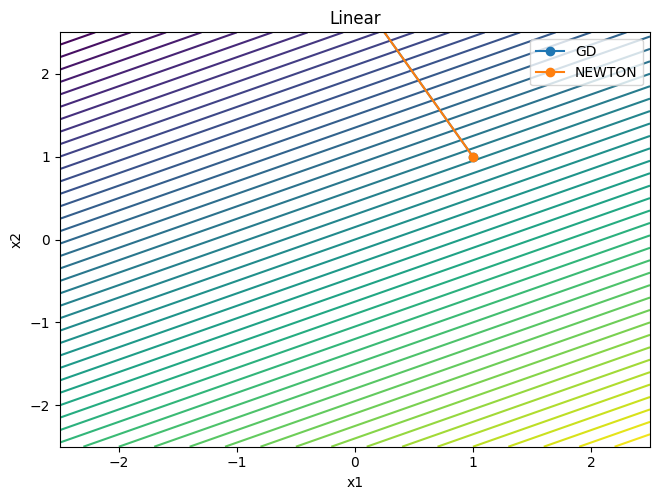

Linear_fvals.png


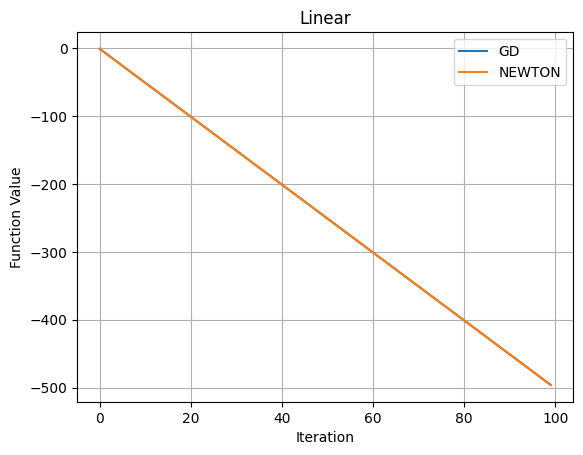

Quadratic_1_contour.png


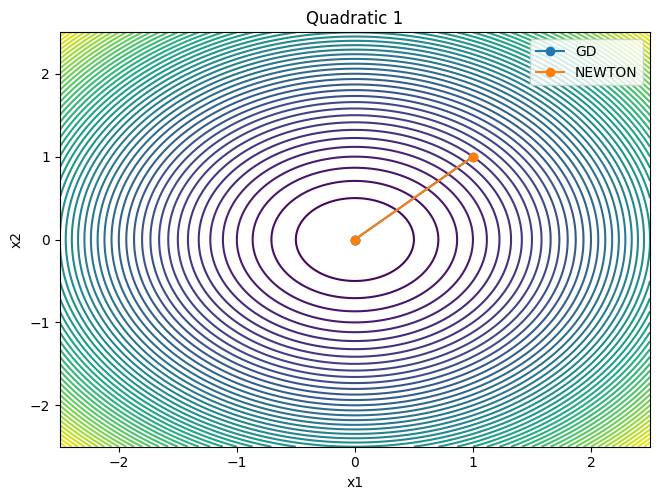

Quadratic_1_fvals.png


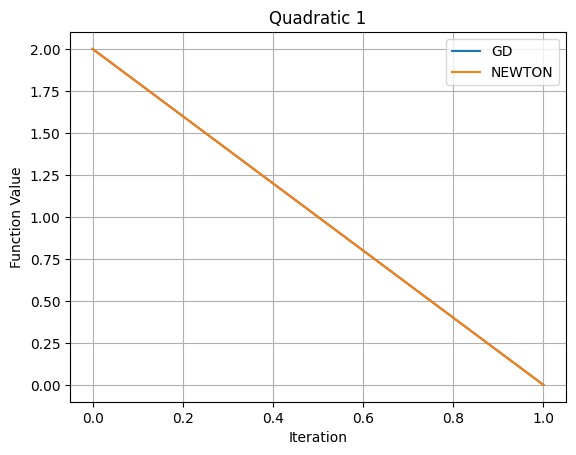

Quadratic_2_contour.png


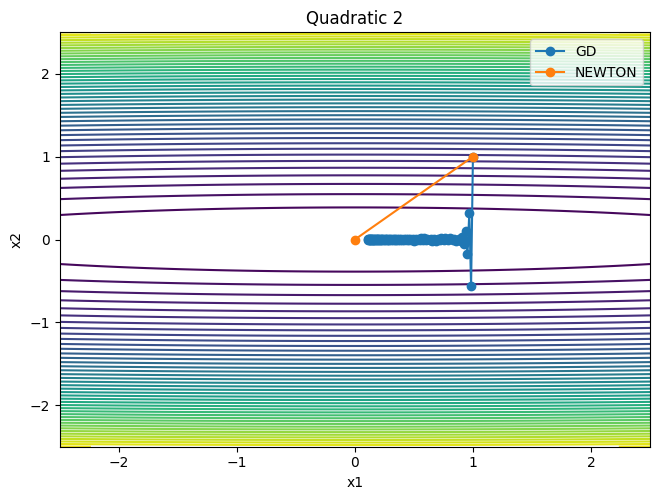

Quadratic_2_fvals.png


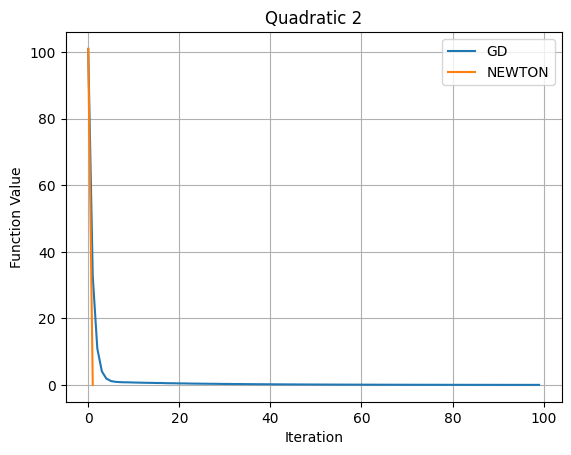

Quadratic_3_contour.png


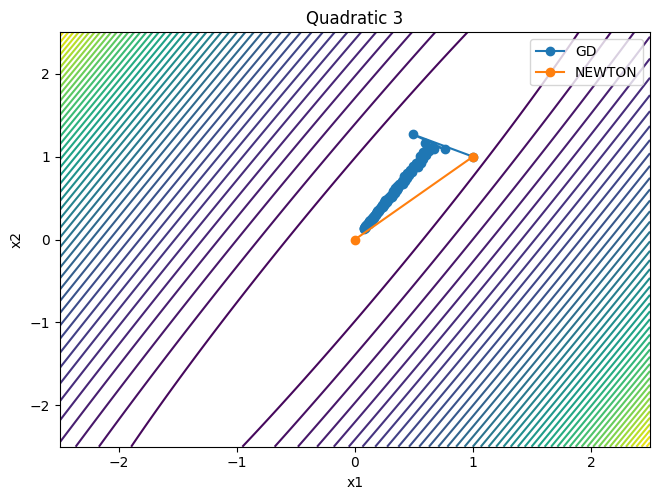

Quadratic_3_fvals.png


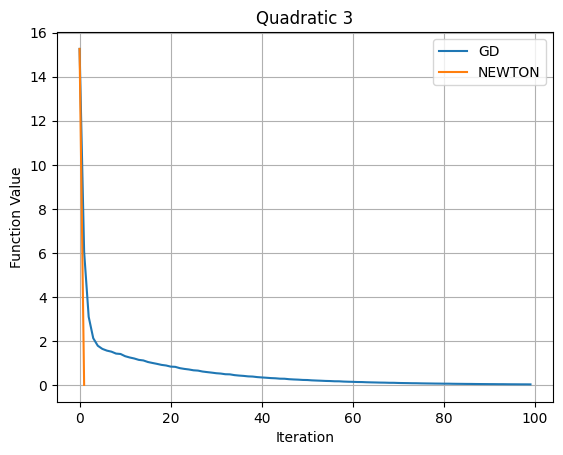

Rosenbrock_contour.png


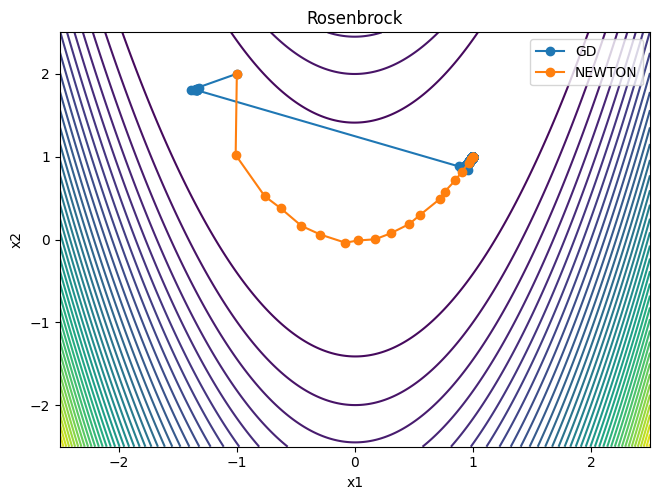

Rosenbrock_fvals.png


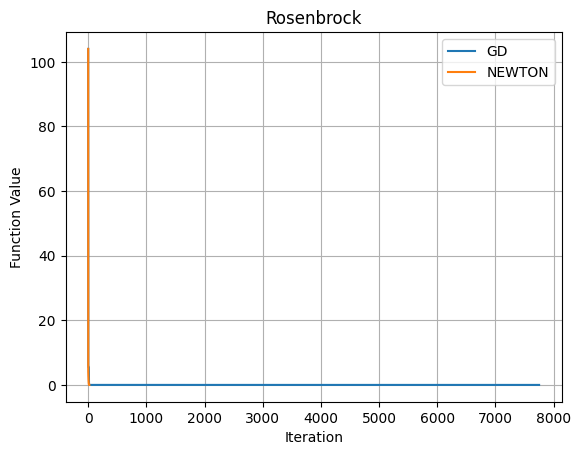

Smoothed_Corner_contour.png


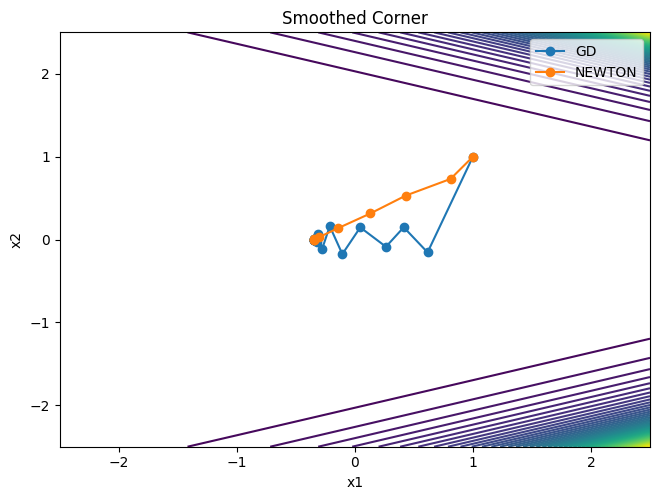

Smoothed_Corner_fvals.png


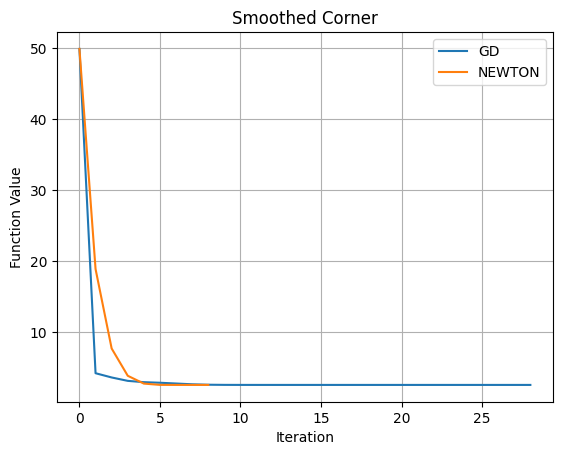

In [27]:
from IPython.display import Image, display
import os

plot_dir = 'output'
files = sorted(os.listdir(plot_dir))

for file in files:
    if file.endswith('.png'):
        print(file)
        display(Image(filename=os.path.join(plot_dir, file)))
